In [1]:
from sklearn.datasets import load_boston
import numpy as np
import torch
from torch import nn
np.random.seed(123)
torch.random.manual_seed(123);
boston = load_boston()
X = boston.data
Y = boston.target
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y[idx]
X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])
X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

In [2]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        """Costruisce un regressore logistico.
         Input:
         in_size: numero di feature in input (es. 13)
         out_size: numero di elementi in output (es. 1)"""
        super(LinearRegressor, self).__init__() #richiamo il costruttore della superclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei moduli di PyTorch

        self.linear = nn.Linear(in_size,out_size)
        
    def forward(self,x):
        """Definisce come processare l'input x"""
        result = self.linear(x)

        return result

In [3]:
from torch.utils.tensorboard import SummaryWriter
lr = 0.01
epochs = 300
writer = SummaryWriter('logs/linear_regressor_1')
#normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
reg = LinearRegressor(13,1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(reg.parameters(),lr=lr)
for e in range(epochs):
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)

    writer.add_scalar('loss/train', l.item(), global_step=e)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    reg.eval()

    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1),Y_testing)
        writer.add_scalar('loss/test', l.item(), global_step=e)

In [4]:
preds_training = reg(X_training_norm)
preds_testing = reg(X_testing_norm)

In [8]:
def MSE(predictions, gt):
    #inseriamo un assert per assicurarci che le due shape siano compatibili
    #questo serve ad evitare problemi indotti dal broadcasting
    assert predictions.shape == gt.shape
    return ((predictions-gt)**2).mean()
#quando chiamiamo il metodo MSE, facciamo un reshape delle predizioni in modo che da shape [N x 1] diventino di shape [1]
print("Mean Squared Error (MSE) di training: {:0.2f}".format(MSE(preds_training.view(-1),Y_training)))
print("Mean Squared Error (MSE) di testing: {:0.2f}".format(MSE(preds_testing.view(-1),Y_testing)))

Mean Squared Error (MSE) di training: 20.52
Mean Squared Error (MSE) di testing: 44.04


In [9]:
def RMSE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions-gt)**2).mean()**(1/2)
print("Root Mean Squared Error (RMSE) di training: {:0.2f}".format(RMSE(preds_training.view(-1),Y_training)))
print("Root Mean Squared Error (RMSE) di testing: {:0.2f}".format(RMSE(preds_testing.view(-1),Y_testing)))

Root Mean Squared Error (RMSE) di training: 4.53
Root Mean Squared Error (RMSE) di testing: 6.64


In [10]:
def MAE(predictions, gt):
    assert predictions.shape == gt.shape
    return ((predictions-gt).abs()).mean()
print("Mean Absolute Error (MAE) di training: {:0.2f}".format(MAE(preds_training.view(-1),Y_training)))
print("Mean Absolute Error (MAE) di testing: {:0.2f}".format(MAE(preds_testing.view(-1),Y_testing)))

Mean Absolute Error (MAE) di training: 3.08
Mean Absolute Error (MAE) di testing: 4.31


In [13]:
from matplotlib import pyplot as plt
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    #calcoliamo tutti gli errori mediante MAE
    errors = np.abs(np.array((predictions.detach()-gt)))
    #prendiamo i valori unici degli erorri e ordiniamoli
    tolerances = sorted(np.unique(errors))
    correct= [] #lista delle "accuracy" relative a ogni soglia
    for t in tolerances:
        correct.append((errors<=t).mean()) #frazione di elementi "correttamente" re    gressi
    AUC = np.trapz(correct, tolerances) #area sotto la curva calcolata col metodo d    ei trapezi
    tot_area = np.max(tolerances)*1 #area totale
    AOC = tot_area - AUC
    #restituiamo le soglie, la frazione di campioni correttamente regressi e l'area    sopra la curva
    return tolerances, correct, AOC

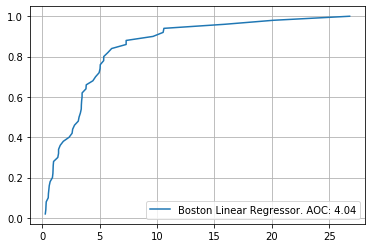

In [14]:
boston_linear_regressor_rec = rec_curve(preds_testing.view(-1),Y_testing)
plt.plot(boston_linear_regressor_rec[0], boston_linear_regressor_rec[1])
plt.legend(['Boston Linear Regressor. AOC: %0.2f'%boston_linear_regressor_rec[2]])
plt.grid()
plt.show()

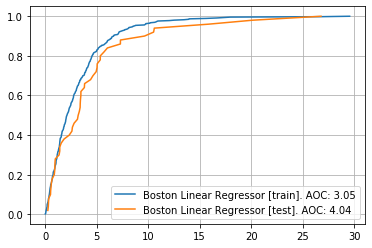

In [15]:
boston_linear_regressor_training_rec = rec_curve(preds_training.view(-1),Y_training)
boston_linear_regressor_testing_rec = rec_curve(preds_testing.view(-1),Y_testing)
plt.plot(boston_linear_regressor_training_rec[0], boston_linear_regressor_training_rec[1])
plt.plot(boston_linear_regressor_testing_rec[0], boston_linear_regressor_testing_rec[1])
plt.legend(['Boston Linear Regressor [train]. AOC: %0.2f'%boston_linear_regressor_training_rec[2],'Boston Linear Regressor [test]. AOC: %0.2f'%boston_linear_regressor_testing_rec[2]])
plt.grid()
plt.show()

In [23]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X=dataset.data
Y=dataset.target
#features
print(X.shape)
#classi target
print(Y.shape)
print(Y[:100])

(569, 30)
(569,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0]


In [24]:
import torch
import numpy as np
np.random.seed(1234)
torch.random.manual_seed(1234);

In [25]:
idx = np.random.permutation(len(X))

In [30]:
X = X[idx]
Y = Y[idx]
X_training = torch.Tensor(X[100:])
Y_training = torch.Tensor(Y[100:])
X_testing = torch.Tensor(X[:100])
Y_testing = torch.Tensor(Y[:100])

In [31]:
X_mean = X_training.mean(0)
X_std = X_training.std(0)
X_training_norm = (X_training-X_mean)/X_std
X_testing_norm = (X_testing-X_mean)/X_std

In [32]:
from torch import nn
linear_regressor = nn.Linear(30,1)

In [33]:
z = linear_regressor(X_training_norm)
print(z[:10]) #stampiamo i primi 10 valori predetti

tensor([[-0.2226],
        [ 0.0421],
        [ 0.0538],
        [ 0.5121],
        [ 0.4431],
        [ 0.3618],
        [-0.0954],
        [-0.3447],
        [ 0.3387],
        [ 0.0734]], grad_fn=<SliceBackward>)


In [34]:
print(z.min())
print(z.max())

tensor(-1.5024, grad_fn=<MinBackward1>)
tensor(1.6246, grad_fn=<MaxBackward1>)


In [35]:
def logistic(z):
    return 1./(1+torch.exp(-z))

In [36]:
p = logistic(z)
print(p[:10])

tensor([[0.4446],
        [0.5105],
        [0.5135],
        [0.6253],
        [0.6090],
        [0.5895],
        [0.4762],
        [0.4147],
        [0.5839],
        [0.5184]], grad_fn=<SliceBackward>)


In [37]:
print(p.min())
print(p.max())

tensor(0.1821, grad_fn=<MinBackward1>)
tensor(0.8354, grad_fn=<MaxBackward1>)


In [38]:
sigmoid=nn.Sigmoid()

In [39]:
p2=sigmoid(z)
print(p2.min())
print(p2.max())

tensor(0.1821, grad_fn=<MinBackward1>)
tensor(0.8354, grad_fn=<MaxBackward1>)


In [40]:
def loss(p,y):
    return (-y*torch.log(p)-(1-y)*torch.log(1-p)).mean()

In [41]:
print(loss(p,Y_training.view(-1,1)))

tensor(0.7721, grad_fn=<MeanBackward0>)


In [42]:
loss = nn.BCELoss()

In [43]:
print(loss(p,Y_training.view(-1,1)))

tensor(0.7721, grad_fn=<BinaryCrossEntropyBackward>)


In [44]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        """Costruisce un regressore logistico.
         Input:
         in_features: numero di feature in input (es. 30)"""
        super(LogisticRegressor, self).__init__() #richiamo il costruttore della su    perclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei m    oduli di PyTorch

        self.linear = nn.Linear(in_features,1) #il regressore logistico restituisce    probabilità
        #quindi il numero di feature di output è "1"
        self.logistic = nn.Sigmoid()

    def forward(self,x):
        """Definisce come processare l'input x"""
        logits = self.linear(x)
        return self.logistic(logits)

In [45]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/logistic_regressor')
lr = 0.01
epochs = 500
# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
#Passo 2: inizializziamo il modello
regressor = LogisticRegressor(30)
loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)
for e in range(epochs):
    regressor.train()
    #Passo 3 & 4: calcoliamo le probabilità
    p = regressor(X_training_norm)

    #Passo 5: calcoliamo il valore della loss
    l = loss(p, Y_training.view(-1,1))
    #Passo 6: calcoliamo il gradiente della loss rispetto a tutti i parametri
    l.backward()
    #facciamo log del valore della loss
    writer.add_scalar('loss/train', l.item(), global_step=e)
    #Passo 7: Aggiorniamo i pesi
    sgd.step()
    #azzeriamo i gradienti per evitare di accumularli
    sgd.zero_grad()
    #calcoliamo e facciamo log la loss di test:
    regressor.eval()
    with torch.set_grad_enabled(False):
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1,1))
        writer.add_scalar('loss/test', l.item(), global_step=e)

In [46]:
#iniziamo calcolando le predizioni del modello dati i pesi allenati
p_test = regressor(X_testing_norm)
#calcoliamo il valore della loss
print(loss(p_test, Y_testing.view(-1,1)))

tensor(0.1880, grad_fn=<BinaryCrossEntropyBackward>)


In [47]:
prob_training = regressor(X_training_norm)
prob_testing = regressor(X_testing_norm)
pred_training = prob_training>=0.5
pred_testing = prob_testing>=0.5
print(pred_testing[:10])

tensor([[False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True]])


In [48]:
def accuracy(pred,gt):
    """Calcola l'accuracy date le predizioni pred
     e le etichette di ground truth gt"""
    correct = pred.view(-1).byte()==gt.view(-1).byte() #pytorch non capisce che 0 = false, quindi usiamo byte
    #conterrà true in corrispondenza degli elementi per i quali è stata predetta la    classe corretta
    #inseriamo "view(-1)" per essere sicuri di lavorare con array monodimensionali
    return float(correct.sum())/len(correct)#conta il numero di predizioni corrette    e divide per il numero totale di predizioni

In [49]:
print("Accuracy di training: {:0.2f}".format(accuracy(pred_training,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(pred_testing,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.95


In [50]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/logistic_regressor_2')
lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
regressor = LogisticRegressor(30)
loss = nn.BCELoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)
for e in range(epochs):
    regressor.train()
    p = regressor(X_training_norm)
    l = loss(p, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)

    regressor.eval()
    with torch.set_grad_enabled(False):
        p = regressor(X_testing_norm)
        l = loss(p, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)

        #calcoliamo e facciamo log dell'accuracy di training a partire dalle predizioni
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In [51]:
def loss2(z,y):
    return (y*torch.log(1+torch.exp(-z))+(1-y)*torch.log(1+torch.exp(z))).mean()

In [52]:
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(in_features,1)

    def forward(self,x):
        logits = self.linear(x)
        return logits

In [53]:
regressor=LogisticRegressor(30)
logistic = nn.Sigmoid()
#logits
z = regressor(X_training_norm)
print(z.min(),z.max())
#probabilità
p = logistic(z)
print(p.min(),p.max())

tensor(-1.0679, grad_fn=<MinBackward1>) tensor(1.2829, grad_fn=<MaxBackward1>)
tensor(0.2558, grad_fn=<MinBackward1>) tensor(0.7829, grad_fn=<MaxBackward1>)


In [54]:
loss_stable = nn.BCEWithLogitsLoss()
l_1=loss_stable(z,Y_training.view(-1,1))
l_2=loss2(z,Y_training.view(-1,1))
print(l_1)
print(l_2)

tensor(0.8065, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8065, grad_fn=<MeanBackward0>)


In [55]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/logistic_regressor_3')
lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
regressor = LogisticRegressor(30)
#inseriamo qui la nuova loss
loss = nn.BCEWithLogitsLoss()
sgd = torch.optim.SGD(regressor.parameters(), lr)
for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()

    #calcoliamo le probabilità
    p=logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)

    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)

        #calcoliamo le probabilità
        p=logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In [56]:
print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.95


In [57]:
preds_training = logistic(regressor(X_training_norm))>=0.5
preds_testing = logistic(regressor(X_testing_norm))>=0.5

In [58]:
from sklearn.metrics import accuracy_score
acc_training = accuracy_score(Y_training,preds_training)
acc_testing = accuracy_score(Y_testing,preds_testing)
print("Accuracy di training: {:0.2f}".format(acc_training))
print("Accuracy di test: {:0.2f}".format(acc_testing))

Accuracy di training: 0.97
Accuracy di test: 0.95


In [59]:
from sklearn.metrics import confusion_matrix
cm_training = confusion_matrix(Y_training,preds_training)
cm_testing = confusion_matrix(Y_testing,preds_testing)
print(cm_training)
print(cm_testing)

[[159   6]
 [  6 298]]
[[43  4]
 [ 1 52]]


In [60]:
cm_testing = cm_testing.astype(float)/cm_testing.sum(1).reshape(-1,1)
print(cm_testing)

[[0.91489362 0.08510638]
 [0.01886792 0.98113208]]


In [61]:
from sklearn.metrics import precision_score, recall_score
scores_training = precision_score(Y_training, preds_training)
scores_testing = recall_score(Y_testing,preds_testing)
print(scores_training)
print(scores_testing)

0.9802631578947368
0.9811320754716981


In [63]:
from sklearn.metrics import f1_score
scores_training = f1_score(Y_training,preds_training, average=None)
scores_testing = f1_score(Y_testing,preds_testing, average=None)
print(scores_training)
print(scores_testing)

[0.96363636 0.98026316]
[0.94505495 0.95412844]


In [64]:
print(scores_training.mean())
print(scores_testing.mean())

0.9719497607655503
0.9495916927109587


In [65]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/logistic_regressor_4')
lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
regressor = LogisticRegressor(30)
loss = nn.BCEWithLogitsLoss()
#specifichiamo il weight_decay
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001)
for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()

    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)

        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In [66]:
print("Accuracy di training: {:0.2f}".format(accuracy(logistic(regressor(X_training_norm))>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(logistic(regressor(X_testing_norm))>=0.5,Y_testing)))

Accuracy di training: 0.97
Accuracy di test: 0.95


In [67]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/logistic_regressor_5')
lr = 0.01
epochs = 500
means = X_training.mean(0)
stds = X_training.std(0)
X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds
regressor = LogisticRegressor(30)
loss = nn.BCEWithLogitsLoss()
#specifichiamo il momentum
sgd = torch.optim.SGD(regressor.parameters(), lr, weight_decay=0.001, momentum=0.9)
for e in range(epochs):
    regressor.train()
    z = regressor(X_training_norm)
    l = loss(z, Y_training.view(-1,1))
    l.backward()
    writer.add_scalar('loss/train',l.item(),global_step=e)
    sgd.step()
    sgd.zero_grad()

    p = logistic(z)
    writer.add_scalar('accuracy/train',accuracy(p>=0.5,Y_training),global_step=e)
    regressor.eval()
    with torch.set_grad_enabled(False):
        z = regressor(X_testing_norm)
        l = loss(z, Y_testing.view(-1,1))
        writer.add_scalar('loss/test',l.item(),global_step=e)

        p = logistic(z)
        writer.add_scalar('accuracy/test',accuracy(p>=0.5,Y_testing),global_step=e)

In [68]:
print("Accuracy di training: {:0.2f}".format(accuracy(regressor(X_training_norm)>=0.5,Y_training)))
print("Accuracy di test: {:0.2f}".format(accuracy(regressor(X_testing_norm)>=0.5,Y_testing)))

Accuracy di training: 0.99
Accuracy di test: 0.96
